In [1]:
import numpy as np
# read in image data as n-dimension array
import os
imgdir = '../dataset'
imgfile1 = os.path.join(imgdir, 'k02-05m-cropped.png')
imgfile2 = os.path.join(imgdir, 'k12-05m-cropped.png')
from skimage import io
img1 = io.imread(imgfile1)
img2 = io.imread(imgfile2)

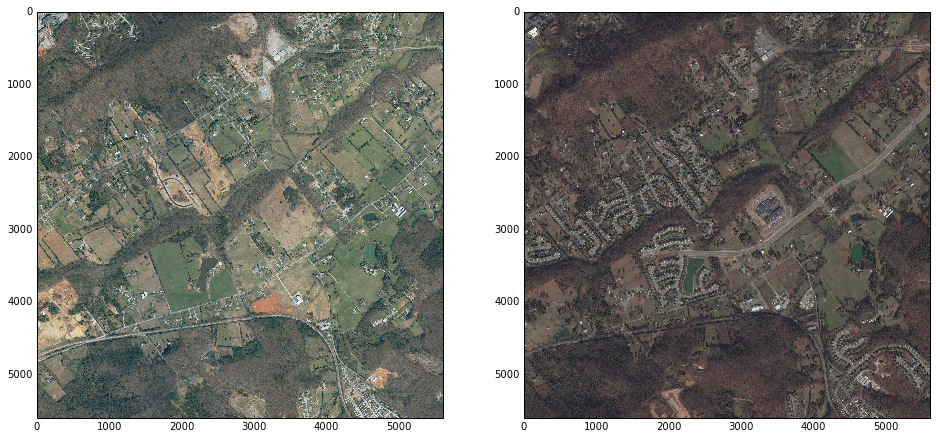

In [2]:
# show data
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,35))
plt.subplot(121).imshow(img1)
plt.subplot(122).imshow(img2)

In [3]:
# divide image arrays into grids based on preset step size
# @param: 2D RGB image as ndarray
# @param: grid_step_size should be divisible to image size
# @return: list of lists of divided ndarray (image grids)
def divide_image_into_grids(image, grid_step_size=50):
    assert image.shape[0]%grid_step==0
    assert image.shape[1]%grid_step==0
    image_grids = list()
    grid_rows = image.shape[0]/grid_step # number of grids along rows
    grid_cols = image.shape[1]/grid_step # number of grids along columns
    for r in range(grid_rows):
        row_image_grids = list()
        for c in range(grid_cols):
            tmp = image[r*grid_step:(r+1)*grid_step-1, c*grid_step:(c+1)*grid_step-1, :]
            row_image_grids.append(tmp)
        image_grids.append(row_image_grids)
    return image_grids

In [4]:
# paraemeter setting to divide image into square grids
grid_step = 280 # unit in pixel, should be divisible to the image size
image_grids_1 = divide_image_into_grids(img1, grid_step)
image_grids_2 = divide_image_into_grids(img2, grid_step)

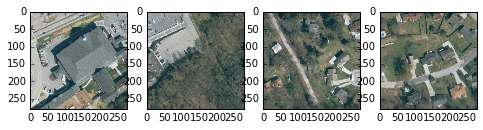

In [5]:
# plot example grids
fig = plt.figure(figsize=(8,20))
plt.subplot(141).imshow(image_grids_1[0][0])
plt.subplot(142).imshow(image_grids_1[0][1])
plt.subplot(143).imshow(image_grids_1[0][2])
plt.subplot(144).imshow(image_grids_1[0][3])

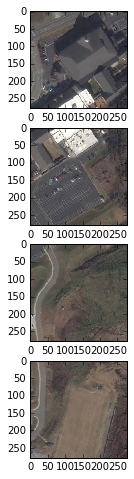

In [6]:
# plot example grids
fig = plt.figure(figsize=(20,8))
plt.subplot(411).imshow(image_grids_2[0][0])
plt.subplot(412).imshow(image_grids_2[1][0])
plt.subplot(413).imshow(image_grids_2[2][0])
plt.subplot(414).imshow(image_grids_2[3][0])

In [7]:
# approximate an image by a Gaussian distribution
# @param image matrix
# @return mean and variance matrix for this gaussian distribution
def image_to_gaussian_distribution(image):
    # convert image pixels into list of vectors
    data = list() # convert each pixel info into a vector
    rows, cols, channels = image.shape
    for r in range(rows):
        index = zip([r]*cols, range(cols))
        img_info = zip(index, image[r])
        vecs = map(lambda x: np.concatenate((np.array(x[0]), x[1]),axis=0) , img_info)
        data.extend(vecs)
    # fit data into a gaussian distribution
    data_mean = np.mean(data, axis=0) # mean vector of gaussian distribution
    data_cov = np.cov(data, rowvar=False) # covariance matrix of gaussian distribution
    return (data_mean, data_cov)

In [8]:
# convert each grid into a gaussian distribution, save gaussian parameters into a list
num_of_rows = len(image_grids_1)
num_of_cols = len(image_grids_1[0])
image_gaussians_1 = list()
for r in range(num_of_rows):
    image_gaussians_1.append(map(image_to_gaussian_distribution, image_grids_1[r]))
image_gaussians_2 = list()
for r in range(num_of_rows):
    image_gaussians_2.append(map(image_to_gaussian_distribution, image_grids_2[r]))
# print dimension of grids of image gaussian distributions
print len(image_gaussians_1), len(image_gaussians_1[0])

20 20


In [9]:
# compute the Kullback–Leibler(KL) divergence between two Gaussian distribution
# @param mean and covariance matrix of two gaussian distributions
# @return KL divergence (asymmetric)
def gaussian_KL_divergence(gsd_1, gsd_2):
    gp_mean, gp_cov = gsd_1[0], gsd_1[1] # mean and covariance of gaussian distr
    gq_mean, gq_cov = gsd_2[0], gsd_2[1]
    term1 = np.log(np.linalg.det(gp_cov) / np.linalg.det(gq_cov))
    mat_inv_q = np.linalg.inv(gq_cov)
    term2 = np.trace(np.matmul(mat_inv_q, gp_cov))
    diff_mean_pq = gp_mean-gq_mean
    term3 = np.matmul(diff_mean_pq, np.matmul(mat_inv_q, np.matrix.transpose(diff_mean_pq)))
    KL_div = (term1 + term2 + term3) / 2
    return KL_div

def symmetric_KL_divergence(gsd_1, gsd_2):
    return (gaussian_KL_divergence(gsd_1, gsd_2)+gaussian_KL_divergence(gsd_2, gsd_1)) / 2

In [10]:
KL_div_map = list()
for r in range(num_of_rows):
    KL_div_map.append(map(symmetric_KL_divergence, image_gaussians_1[r], image_gaussians_2[r]))
print len(KL_div_map), len(KL_div_map[0])

20 20


/Users/Jerry/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


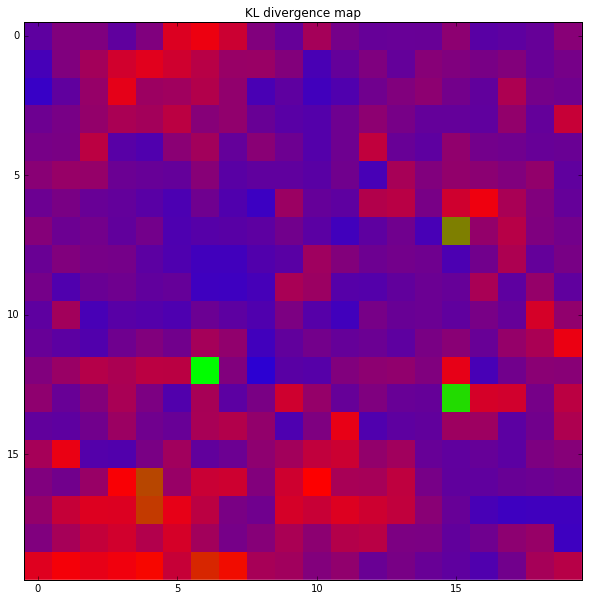

In [11]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.imshow(KL_div_map, cmap=plt.get_cmap('brg'), vmin=0, vmax=50, interpolation='none')
plt.title("KL divergence map")
ax.legend()
plt.show()

In [12]:
# Build GMM model-based clustering model by subset of KL divergence map
KL_values = np.vstack(np.ravel(KL_div_map)) # flatten the 2D matrix to 1D array, then transpose into column
sample_ratio = 0.6 # subset ratio in full data set
import random
KL_samples = random.sample(KL_values, int(sample_ratio*len(KL_values))) # select subset
from sklearn import mixture
K = 8 # number of gaussian mixtures
gmm = mixture.GaussianMixture(n_components=K, covariance_type='spherical')
gmm.fit(KL_samples) # training GMM model

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=8, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

In [13]:
# Apply GMM clustering model to categorize the changes on KL divergence map
KL_change_map = list()
for KL_div_row in KL_div_map:
    KL_change_map.append(gmm.predict(np.vstack(KL_div_row)))
print len(KL_change_map), len(KL_change_map[0])

20 20


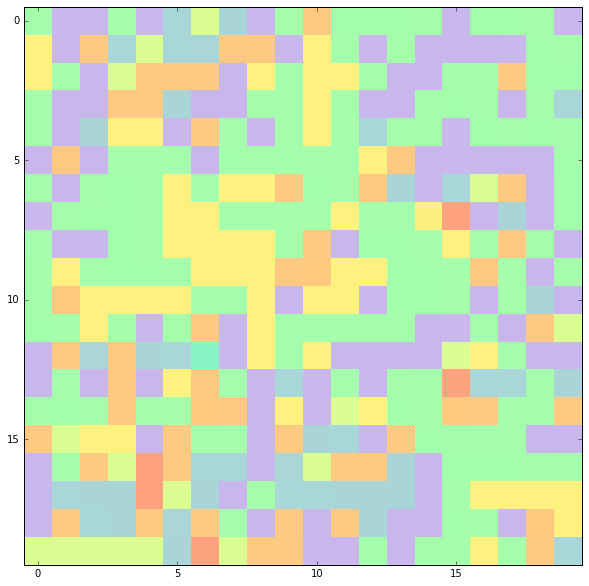

In [14]:
# Plot the change map to detect changes
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
from matplotlib import colors
cmap = colors.LinearSegmentedColormap.from_list('segmented', ['#3366cc','#33cc33', '#ffcc00', '#ff0000'], N=K)
cmap1 = colors.LinearSegmentedColormap.from_list(11, colors =['MediumPurple', 'SpringGreen', 'Yellow', 'OrangeRed'],N=K)
plt.imshow(KL_change_map, cmap=cmap1, interpolation='none', alpha=0.5)
ax.legend()
plt.show()